# Covariate indipendenti dal tempo {#sec-growth-covariates}

**Prerequisiti**

**Concetti e Competenze Chiave**

**Preparazione del Notebook**

In [1]:
here::here("code", "_common.R") |>
    source()

# Load packages
if (!requireNamespace("pacman")) install.packages("pacman")
pacman::p_load(DT, kableExtra, lme4, emmeans)

Caricamento dei namespace richiesti: pacman



## Introduzione

Nell'ambito degli studi sui modelli di crescita lineare, una questione rilevante è capire in che modo le differenze individuali nelle traiettorie di cambiamento siano influenzate da altre variabili. Il presente capitolo si dedica all'integrazione di covariate invarianti nel tempo in questi modelli di crescita. 

Le covariate invarianti nel tempo sono quelle variabili che rimangono costanti per ogni individuo durante il periodo di studio. Esempi tipici includono il genere, le condizioni sperimentali, lo stato socio-economico, e altri attributi che non subiscono modifiche nel tempo. In termini di modellazione, queste variabili vengono trattate come fattori indipendenti in un modello di regressione multipla, dove l'intercetta e la pendenza del modello di crescita lineare fungono da variabili dipendenti. Le covariate possono assumere vari formati: possono essere continue (es. età), ordinali (es. livelli di istruzione) o categoriche (es. genere).

Includere covariate invarianti nel tempo permette di esplorare come le differenze individuali nella traiettoria di crescita (sia in termini di intercetta che di pendenza) siano associate a queste variabili. Questo approccio offre la possibilità di indagare le ragioni sottostanti le diverse modalità di cambiamento tra gli individui. 

- È importante sottolineare che, pur fornendo insights significativi, i risultati ottenuti da questi modelli non implicano relazioni causali. Questi modelli hanno limitazioni simili a quelle dei modelli di regressione standard in termini di inferenza causale.
- È cruciale considerare il contesto nel quale le covariate invarianti nel tempo sono state raccolte. Se queste provengono da un contesto sperimentale con assegnazione casuale, le inferenze potrebbero essere più robuste. Tuttavia, nel caso di dati osservazionali, è necessario un'attenta considerazione per evitare interpretazioni errate o eccessivamente assertive riguardo la causalità.

In sintesi, l'integrazione di covariate invarianti nel tempo nei modelli di crescita lineare fornisce una visione più dettagliata delle dinamiche individuali e del modo in cui vari fattori possono influenzare le traiettorie di crescita. Questo approccio arricchisce la comprensione dei fenomeni studiati, pur richiedendo un'interpretazione cauta e informata dei risultati ottenuti.

Per questo esempio considereremo i dati di prestazione matematica dal data set NLSY-CYA Long Data [si veda {cite:t}`grimm2016growth`]. Iniziamo a leggere i dati.

In [2]:
# set filepath for data file
filepath <- "https://raw.githubusercontent.com/LRI-2/Data/main/GrowthModeling/nlsy_math_long_R.dat"
# read in the text data file using the url() function
dat <- read.table(
  file = url(filepath),
  na.strings = "."
) # indicates the missing data designator
# copy data with new name
nlsy_math_long <- dat

# Add names the columns of the data set
names(nlsy_math_long) <- c(
  "id", "female", "lb_wght",
  "anti_k1", "math", "grade",
  "occ", "age", "men",
  "spring", "anti"
)

# view the first few observations in the data set
head(nlsy_math_long, 10)

,id,female,lb_wght,anti_k1,math,grade,occ,age,men,spring,anti
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,201,1,0,0,38,3,2,111,0,1,0
2,201,1,0,0,55,5,3,135,1,1,0
3,303,1,0,1,26,2,2,121,0,1,2
4,303,1,0,1,33,5,3,145,0,1,2
5,2702,0,0,0,56,2,2,100,NA,1,0
6,2702,0,0,0,58,4,3,125,NA,1,2
7,2702,0,0,0,80,8,4,173,NA,1,2
8,4303,1,0,0,41,3,2,115,0,0,1
9,4303,1,0,0,58,4,3,135,0,1,2


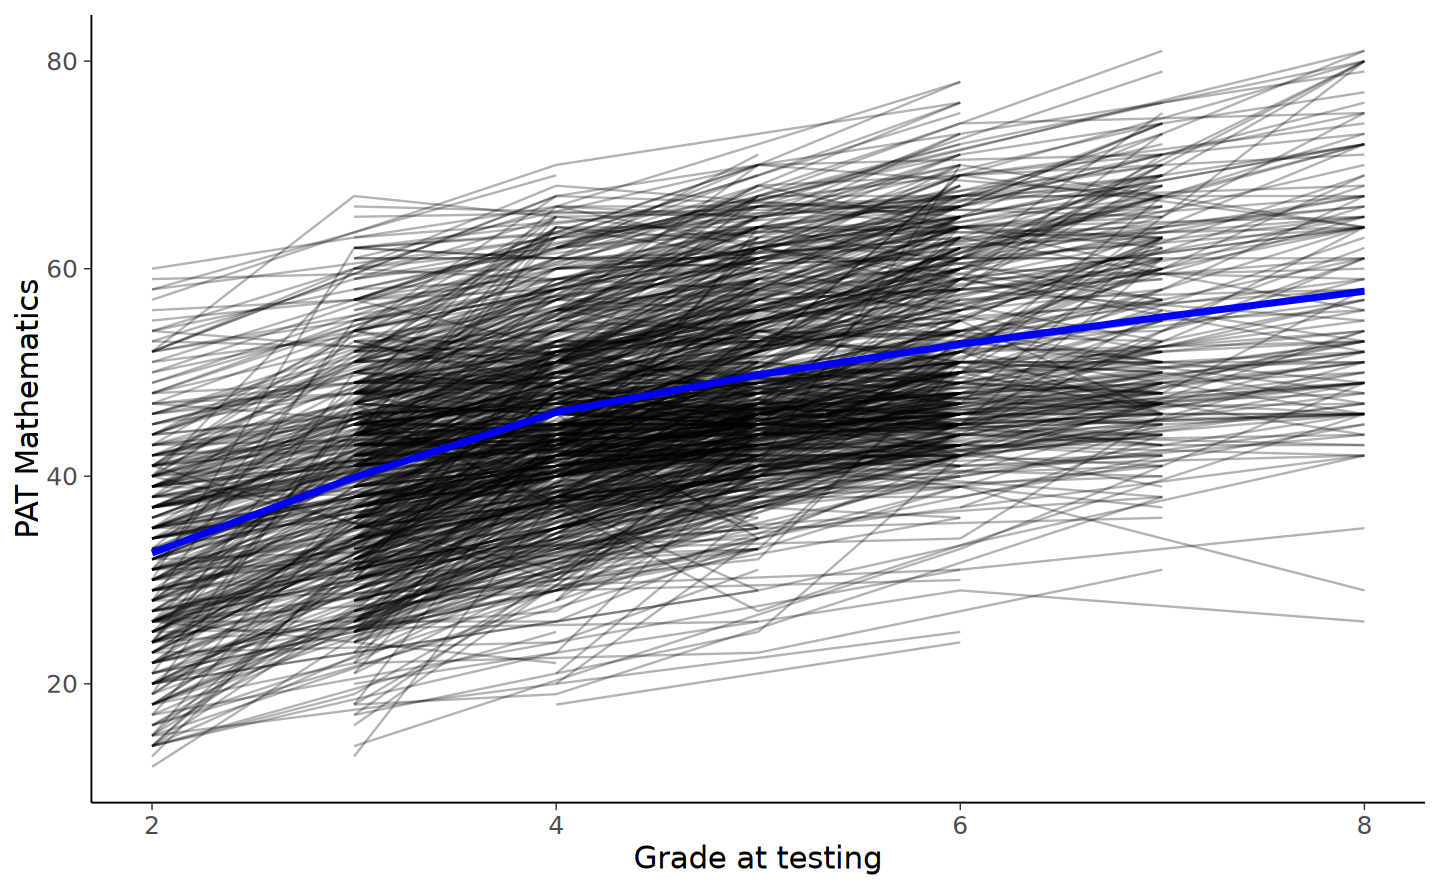

In [3]:
nlsy_math_long |>
  ggplot(
    aes(grade, math, group = id)
  ) +
  geom_line(alpha = 0.3) + # add individual line with transparency
  stat_summary( # add average line
    aes(group = 1),
    fun = mean,
    geom = "line",
    linewidth = 1.5,
    color = "blue"
  ) +
  labs(x = "Grade at testing", y = "PAT Mathematics") 


Per ottenere una visione più dettagliata dei cambiamenti a livello individuale, possiamo selezionare casualmente un campione di 20 individui e registrare, per ciascuno di essi, l'evoluzione dei loro punteggi in matematica nel tempo.

`geom_line()`: Each group consists of only one observation.
i Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
i Do you need to adjust the group aesthetic?


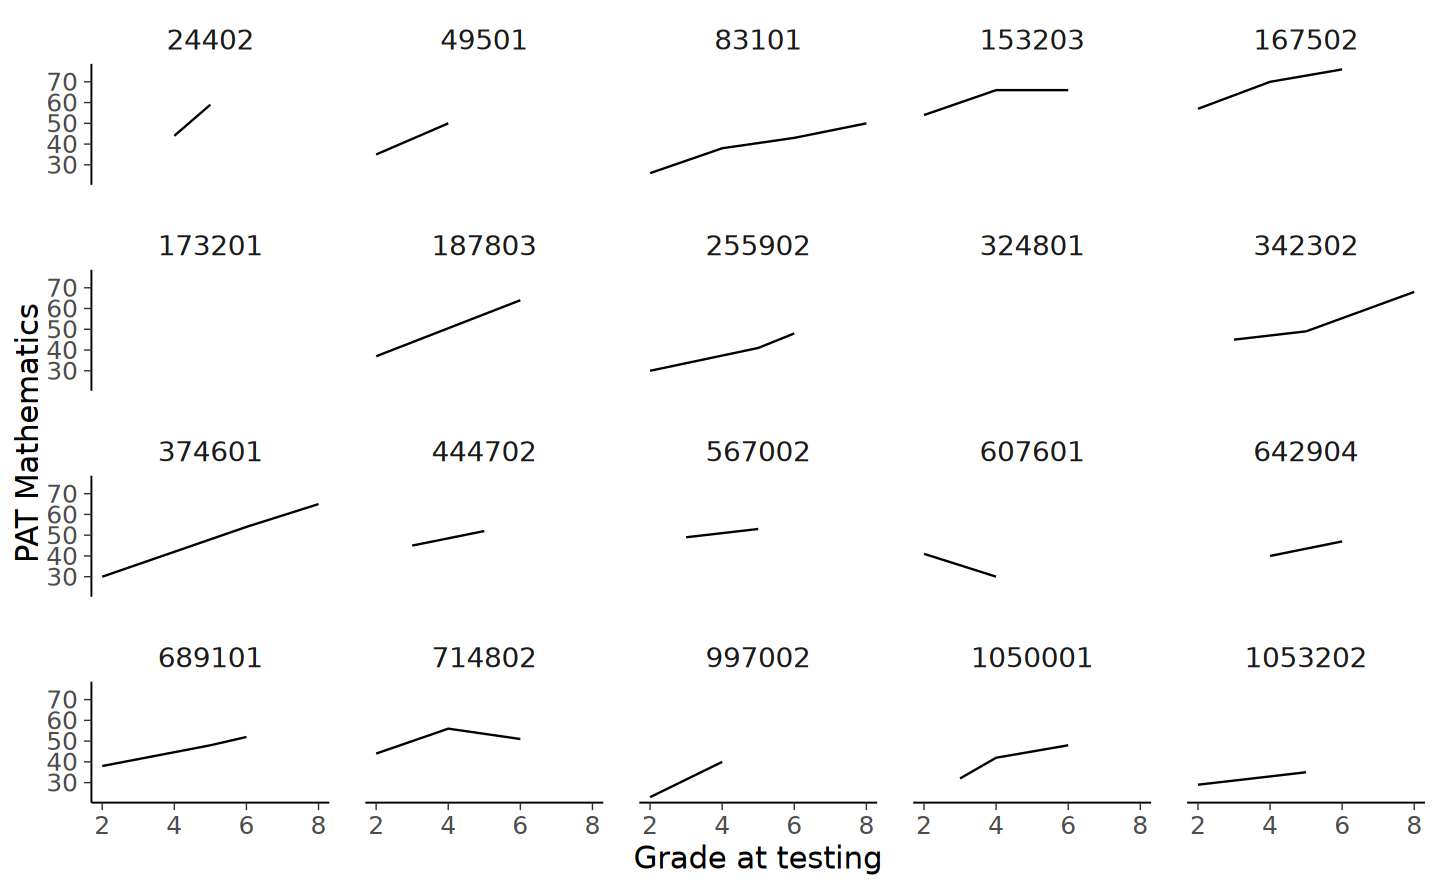

In [4]:
# sample 20 ids
people <- unique(nlsy_math_long$id) %>% sample(20)
# do separate graph for each individual
nlsy_math_long %>% 
  filter(id %in% people) %>%  # filter only sampled cases
  ggplot(aes(grade, math, group = 1)) +
  geom_line() +
  facet_wrap(~id) + # a graph for each individual
  labs(x = "Grade at testing", y = "PAT Mathematics") 

Per semplicità, leggiamo gli stessi dati in formato wide da un file.

In [ ]:
# set filepath for data file
filepath <- "https://raw.githubusercontent.com/LRI-2/Data/main/GrowthModeling/nlsy_math_wide_R.dat"

# read in the text data file using the url() function
dat <- read.table(
  file = url(filepath),
  na.strings = "."
) # indicates the missing data designator

# copy data with new name
nlsy_math_wide <- dat

# Give the variable names
names(nlsy_math_wide) <- c(
  "id", "female", "lb_wght", "anti_k1",
  "math2", "math3", "math4", "math5", "math6", "math7", "math8",
  "age2", "age3", "age4", "age5", "age6", "age7", "age8",
  "men2", "men3", "men4", "men5", "men6", "men7", "men8",
  "spring2", "spring3", "spring4", "spring5", "spring6", "spring7", "spring8",
  "anti2", "anti3", "anti4", "anti5", "anti6", "anti7", "anti8"
)


# view the first few observations (and columns) in the data set
head(nlsy_math_wide[, 1:11], 10)

,id,female,lb_wght,anti_k1,math2,math3,math4,math5,math6,math7,math8
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,201,1,0,0,NA,38,NA,55,NA,NA,NA
2,303,1,0,1,26,NA,NA,33,NA,NA,NA
3,2702,0,0,0,56,NA,58,NA,NA,NA,80
4,4303,1,0,0,NA,41,58,NA,NA,NA,NA
5,5002,0,0,4,NA,NA,46,NA,54,NA,66
6,5005,1,0,0,35,NA,50,NA,60,NA,59
7,5701,0,0,2,NA,62,61,NA,NA,NA,NA
8,6102,0,0,0,NA,NA,55,67,NA,81,NA
9,6801,1,0,0,NA,54,NA,62,NA,66,NA


Specifichiamo il modello SEM (si noti che, anche in questo caso, la scrittura del modello può essere semplificata usando la funzione `growth`).

I covarianti invarianti nel tempo valutati qui includono `lb_wght`, una variabile dicotomica codificata come dummy che indica se il bambino aveva un peso alla nascita normale (codificato 0) o basso (codificato 1), e `anti_k1`, una variabile continua con valori che variano da 0 a 8 indicando il grado in cui il bambino manifestava comportamenti antisociali all'asilo o in prima elementare (punteggi più alti indicano un comportamento più antisociale).

In [6]:
#writing out linear growth model with tic in full SEM way 
lg_math_tic_lavaan_model <- '
    #latent variable definitions
            #intercept
              eta1 =~ 1*math2+
                      1*math3+
                      1*math4+
                      1*math5+
                      1*math6+
                      1*math7+
                      1*math8
            #linear slope
              eta2 =~ 0*math2+
                      1*math3+
                      2*math4+
                      3*math5+
                      4*math6+
                      5*math7+
                      6*math8

          #factor variances
            eta1 ~~ eta1
            eta2 ~~ eta2

          #factor covariance
            eta1 ~~ eta2

          #manifest variances (set equal by naming theta)
            math2 ~~ theta*math2
            math3 ~~ theta*math3
            math4 ~~ theta*math4
            math5 ~~ theta*math5
            math6 ~~ theta*math6
            math7 ~~ theta*math7
            math8 ~~ theta*math8

          #latent means (freely estimated)
            eta1 ~ 1
            eta2 ~ 1

          #manifest means (fixed to zero)
            math2 ~ 0*1
            math3 ~ 0*1
            math4 ~ 0*1
            math5 ~ 0*1
            math6 ~ 0*1
            math7 ~ 0*1
            math8 ~ 0*1

        #Time invariant covaraite
        #regression of time-invariant covariate on intercept and slope factors
            eta1 ~ lb_wght + anti_k1
            eta2 ~ lb_wght + anti_k1

        #variance of TIV covariates
            lb_wght ~~ lb_wght
            anti_k1 ~~ anti_k1

        #covariance of TIV covariates
            lb_wght ~~ anti_k1

        #means of TIV covariates (freely estimated)
            lb_wght ~ 1
            anti_k1 ~ 1
' #end of model definition

Adattiamo il modello ai dati.

In [7]:
lg_math_tic_lavaan_fit <- sem(lg_math_tic_lavaan_model,
  data = nlsy_math_wide,
  meanstructure = TRUE,
  estimator = "ML",
  missing = "fiml"
)

Warning message:
"lavaan->lav_data_full():  
   some observed variances are (at least) a factor 1000 times larger than 
   others; use varTable(fit) to investigate"
Warning message:
"lavaan->lav_data_full():  
   due to missing values, some pairwise combinations have less than 10% 
   coverage; use lavInspect(fit, "coverage") to investigate."
Warning message:
"lavaan->lav_mvnorm_missing_h1_estimate_moments():  
   Maximum number of iterations reached when computing the sample moments 
   using EM; use the em.h1.iter.max= argument to increase the number of 
   iterations"


Esaminiamo la soluzione ottenuta.

In [8]:
summary(lg_math_tic_lavaan_fit, fit.measures = TRUE) |>
    print()

lavaan 0.6-19 ended normally after 110 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        21
  Number of equality constraints                     6

  Number of observations                           933
  Number of missing patterns                        61

Model Test User Model:
                                                      
  Test statistic                               220.221
  Degrees of freedom                                39
  P-value (Chi-square)                           0.000

Model Test Baseline Model:

  Test statistic                               892.616
  Degrees of freedom                                36
  P-value                                        0.000

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    0.788
  Tucker-Lewis Index (TLI)                       0.805
                                  

Interpretazione dei risultati per `eta1` (Intercetta).

- **lb_wght**: L'effetto stimato di `lb_wght` sull'intercetta (eta1) è di -2.716 con uno standard error di 1.294. Questo valore di -2.716 indica che avere un peso alla nascita basso (codificato come 1) è associato ad una riduzione media di 2.716 unità nel valore iniziale di `eta1`, rispetto a un peso alla nascita normale (codificato come 0). Questo risultato è statisticamente significativo, come indicato dal valore di P (0.036), che è inferiore a 0.05.
- **anti_k1**: Per `anti_k1`, l'effetto stimato sull'intercetta è di -0.551 con uno standard error di 0.232. Questo suggerisce che per ogni unità di aumento nel punteggio di comportamento antisociale (anti_k1), il valore iniziale di `eta1` diminuisce in media di 0.551 unità. Anche questo risultato è statisticamente significativo, con un valore di P di 0.018.

Interpretazione dei risultati per `eta2` (Pendenza).

- **lb_wght**: Per la pendenza (eta2), l'effetto stimato di `lb_wght` è di 0.625 con uno standard error di 0.333. Ciò indica che avere un peso alla nascita basso è associato ad un aumento medio di 0.625 unità nella pendenza di `eta2`, rispetto a un peso normale alla nascita. Tuttavia, questo risultato non è statisticamente significativo al livello del 5%, dato che il valore di P è 0.061, che è leggermente superiore a 0.05.
- **anti_k1**: L'effetto stimato di `anti_k1` sulla pendenza è molto piccolo (-0.019) e non è statisticamente significativo (valore di P = 0.743), suggerendo che non c'è una relazione chiara tra il comportamento antisociale in età precoce e il cambiamento nel tempo di `eta2`.

In sintesi, il peso alla nascita basso e i comportamenti antisociali sembrano influenzare negativamente il valore iniziale (intercetta) del costrutto misurato. Il peso alla nascita e i comportamenti antisociali non sembrano avere un impatto significativo sulla pendenza.

Creiamo un diagramma di percorso.

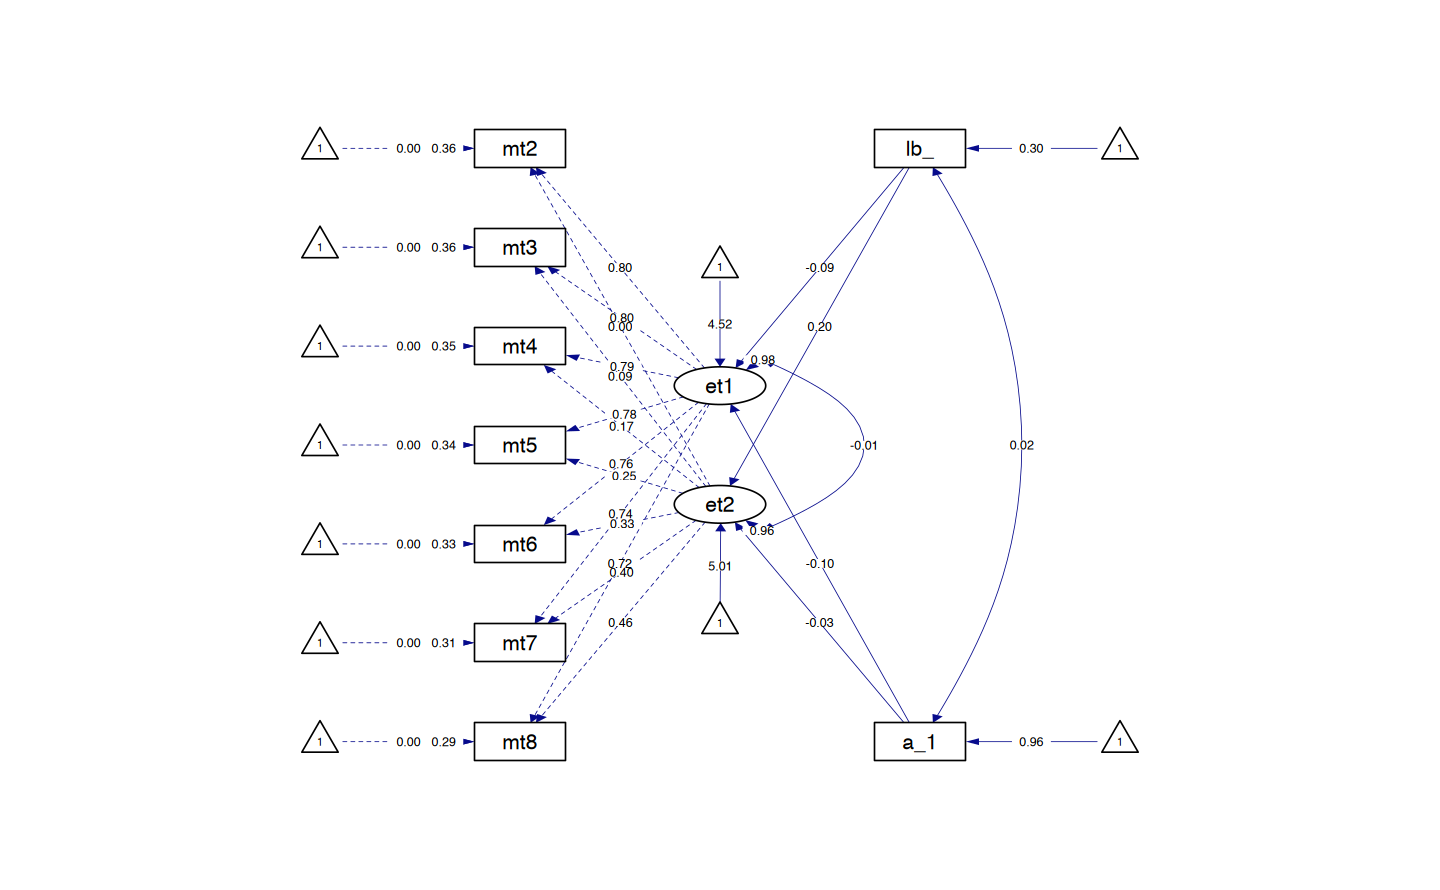

In [9]:
lg_math_tic_lavaan_fit |>
    semPaths(
        style = "lisrel",
        whatLabels = "std", edge.label.cex = .6,
        label.prop = 0.9, edge.label.color = "black", rotation = 4,
        equalizeManifests = FALSE, optimizeLatRes = TRUE, node.width = 1.5,
        edge.width = 0.5, shapeMan = "rectangle", shapeLat = "ellipse",
        shapeInt = "triangle", sizeMan = 4, sizeInt = 2, sizeLat = 4,
        curve = 2, unCol = "#070b8c"
    )

### Valutare il contributo delle covariate

Una domanda comune in questo approccio per comprendere le associazioni tra covarianti invarianti nel tempo e traiettorie individuali è se l'aggiunta dei covarianti invarianti nel tempo sia stata utile. Nel framework di modellazione multilivello, i -2LL ottenuti quando si adattano modelli con e senza i covarianti invarianti nel tempo possono essere confrontati direttamente (se nessun partecipante è stato escluso dall'analisi a causa di dati incompleti sui covarianti invarianti nel tempo), fornendo un modo per valutare l'adattamento relativo del modello. Specificamente, possiamo esaminare la differenza tra i -2LL rispetto alla differenza nel numero di parametri stimati (o differenza nei gradi di libertà). 

In [10]:
#writing out linear growth model with tic in full SEM way 
lg_math_ticZERO_lavaan_model <- '
    #latent variable definitions
            #intercept
              eta1 =~ 1*math2+
                      1*math3+
                      1*math4+
                      1*math5+
                      1*math6+
                      1*math7+
                      1*math8
            #linear slope
              eta2 =~ 0*math2+
                      1*math3+
                      2*math4+
                      3*math5+
                      4*math6+
                      5*math7+
                      6*math8

          #factor variances
            eta1 ~~ eta1
            eta2 ~~ eta2

          #factor covariance
            eta1 ~~ eta2

          #manifest variances (set equal by naming theta)
            math2 ~~ theta*math2
            math3 ~~ theta*math3
            math4 ~~ theta*math4
            math5 ~~ theta*math5
            math6 ~~ theta*math6
            math7 ~~ theta*math7
            math8 ~~ theta*math8

          #latent means (freely estimated)
            eta1 ~ 1
            eta2 ~ 1

          #manifest means (fixed to zero)
            math2 ~ 0*1
            math3 ~ 0*1
            math4 ~ 0*1
            math5 ~ 0*1
            math6 ~ 0*1
            math7 ~ 0*1
            math8 ~ 0*1

        #Time invariant covaraite
          #regression of time-invariant covariate on intercept and slope factors
          #FIXED to 0
            eta1 ~ 0*lb_wght + 0*anti_k1
            eta2 ~ 0*lb_wght + 0*anti_k1

        #variance of TIV covariates
            lb_wght ~~ lb_wght
            anti_k1 ~~ anti_k1

        #covariance of TIV covaraites
            lb_wght ~~ anti_k1

        #means of TIV covariates (freely estimated)
            lb_wght ~ 1
            anti_k1 ~ 1
' #end of model definition

Adattiamo il modello ai dati.

In [11]:
lg_math_ticZERO_lavaan_fit <- sem(lg_math_ticZERO_lavaan_model,
  data = nlsy_math_wide,
  meanstructure = TRUE,
  estimator = "ML",
  missing = "fiml"
)

Warning message:
"lavaan->lav_data_full():  
   some observed variances are (at least) a factor 1000 times larger than 
   others; use varTable(fit) to investigate"
Warning message:
"lavaan->lav_data_full():  
   due to missing values, some pairwise combinations have less than 10% 
   coverage; use lavInspect(fit, "coverage") to investigate."
Warning message:
"lavaan->lav_mvnorm_missing_h1_estimate_moments():  
   Maximum number of iterations reached when computing the sample moments 
   using EM; use the em.h1.iter.max= argument to increase the number of 
   iterations"


Esaminiamo il risultato ottenuto. 

In [12]:
summary(lg_math_ticZERO_lavaan_fit, fit.measures = TRUE) |>
    print()

lavaan 0.6-19 ended normally after 85 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        17
  Number of equality constraints                     6

  Number of observations                           933
  Number of missing patterns                        61

Model Test User Model:
                                                      
  Test statistic                               234.467
  Degrees of freedom                                43
  P-value (Chi-square)                           0.000

Model Test Baseline Model:

  Test statistic                               892.616
  Degrees of freedom                                36
  P-value                                        0.000

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    0.776
  Tucker-Lewis Index (TLI)                       0.813
                                   

Generiamo il diagramma di percorso.

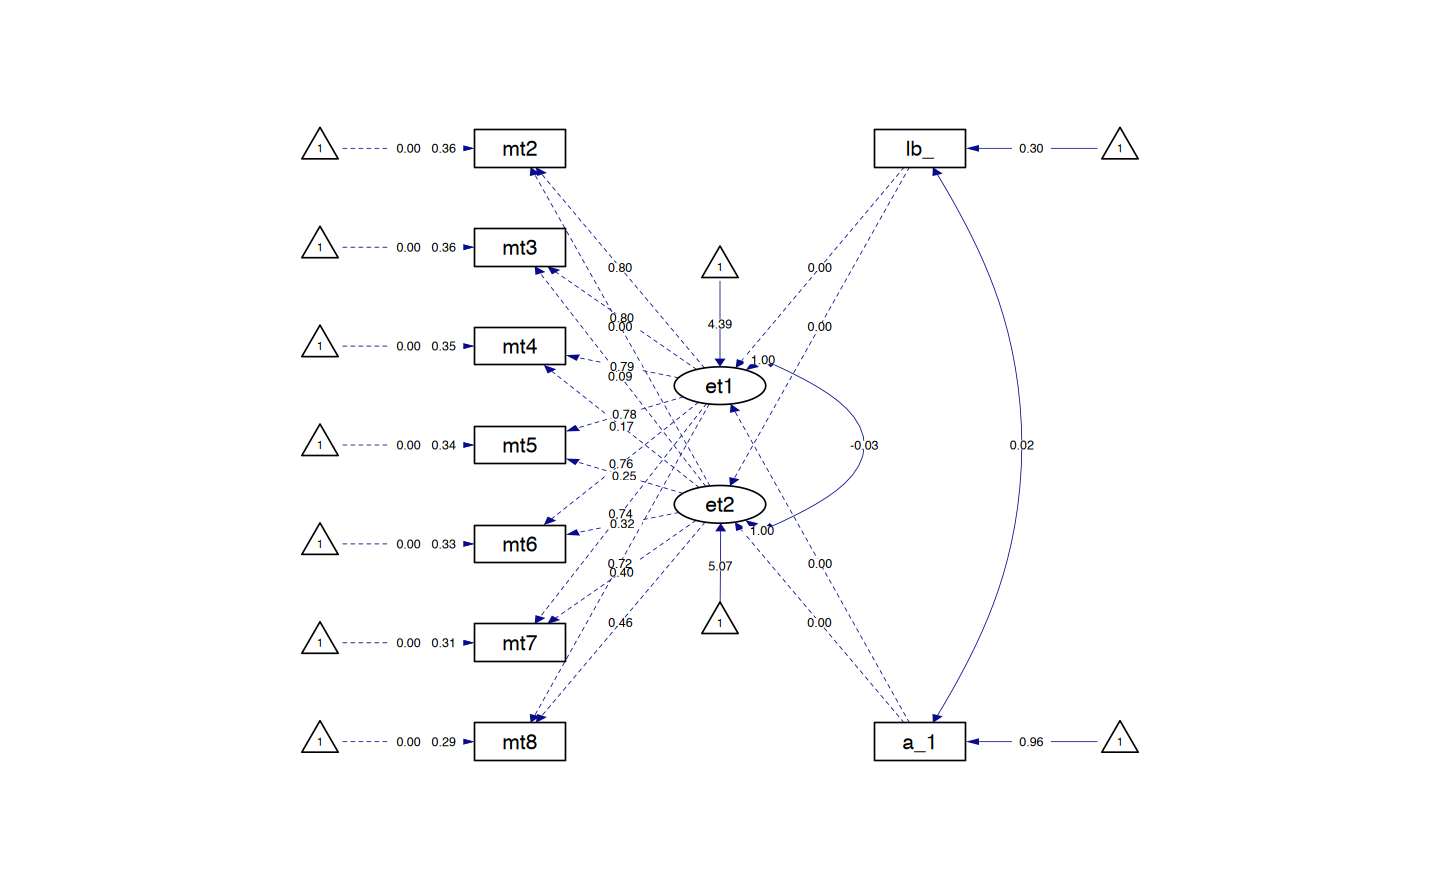

In [13]:
lg_math_ticZERO_lavaan_fit |>
    semPaths(
        style = "lisrel",
        whatLabels = "std", edge.label.cex = .6,
        label.prop = 0.9, edge.label.color = "black", rotation = 4,
        equalizeManifests = FALSE, optimizeLatRes = TRUE, node.width = 1.5,
        edge.width = 0.5, shapeMan = "rectangle", shapeLat = "ellipse",
        shapeInt = "triangle", sizeMan = 4, sizeInt = 2, sizeLat = 4,
        curve = 2, unCol = "#070b8c"
    )

Eseguiamo il confronto tra i due modelli mediante il test del rapporto tra verosimiglianze.

In [14]:
lavTestLRT(lg_math_tic_lavaan_fit, lg_math_ticZERO_lavaan_fit) |>
    print()


Chi-Squared Difference Test

                           Df   AIC   BIC  Chisq Chisq diff    RMSEA
lg_math_tic_lavaan_fit     39 19600 19673 220.22                    
lg_math_ticZERO_lavaan_fit 43 19606 19660 234.47     14.245 0.052395
                           Df diff Pr(>Chisq)   
lg_math_tic_lavaan_fit                          
lg_math_ticZERO_lavaan_fit       4   0.006552 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Nel nostro esempio, il -2LL per il modello di crescita lineare era 15.937 e il -2LL per il modello di crescita lineare con due predittori invarianti nel tempo (basso peso alla nascita e comportamenti antisociali) dell'intercetta e della pendenza era 15.923, una differenza di 14. La differenza nel numero di parametri stimati era (19 – 15) = 4. Quindi, il miglioramento dell'adattamento era significativo (χ2(4) = 14, p < .01), indicando che basso peso alla nascita e comportamenti antisociali erano predittori utili. Parallelamente alle differenze nei -2LL, le differenze in AIC e BIC hanno anche indicato un miglioramento nell'adattamento del modello (criteri di informazione più bassi indicano un migliore adattamento) quando i covarianti invarianti nel tempo erano inclusi nel modello.

Nel framework di modellazione delle equazioni strutturali, è tipico valutare l'adattamento globale (ad esempio, RMSEA, CFI, TLI); tuttavia, raramente l'aggiunta di covarianti invarianti nel tempo cambia significativamente questi indici. L'adattamento relativo dei modelli può essere informativo come nel framework di modellazione multilivello. Come sopra, le differenze nei -2LL (o χ2) possono essere calcolate per testare se l'inclusione dei covarianti invarianti nel tempo ha migliorato significativamente l'adattamento del modello. Si noti che, nel framework di modellazione delle equazioni strutturali, il modello di confronto (baseline) non è semplicemente un modello senza i covarianti invarianti nel tempo. Piuttosto, è un modello che include i covarianti invarianti nel tempo ma vincola i loro effetti sull'intercetta e sulla pendenza a 0. 


## Confronto con il modello misto

Eseguiamo ora l'analisi statistica utilizzando un modello misto con intercetta e pendenza casuale. Confronteremo un modello ridotto, che include solo l'effetto del tempo, con un modello completo che include le covariate esaminate in precedenza. Il modello completo include gli effetti principali delle covariate e l'interazione tra le covariate e il tempo.

Adattiamo il modello "completo".

In [15]:
nlsy_math_long$grade_c2 <- nlsy_math_long$grade-2

fit2_lmer <- lmer(
    math ~ 1 + grade_c2 + lb_wght + anti_k1 + I(grade_c2 * lb_wght) + I(grade_c2 * anti_k1) +
        (1 + grade_c2 | id),
    data = nlsy_math_long,
    REML = FALSE,
    na.action = na.exclude
)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.00577269 (tol = 0.002, component 1)"


Esaminiamo i risultati ottenuti.

In [16]:
summary(fit2_lmer)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: math ~ 1 + grade_c2 + lb_wght + anti_k1 + I(grade_c2 * lb_wght) +  
    I(grade_c2 * anti_k1) + (1 + grade_c2 | id)
   Data: nlsy_math_long

     AIC      BIC   logLik deviance df.resid 
 15943.1  16000.2  -7961.6  15923.1     2211 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-3.07986 -0.52517 -0.00867  0.53079  2.53455 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 id       (Intercept) 63.0653  7.941         
          grade_c2     0.7141  0.845    -0.01
 Residual             36.2543  6.021         
Number of obs: 2221, groups:  id, 932

Fixed effects:
                      Estimate Std. Error t value
(Intercept)           36.28983    0.49630  73.120
grade_c2               4.31521    0.12060  35.782
lb_wght               -2.71621    1.29359  -2.100
anti_k1               -0.55087    0.23246  -2.370
I(grade_c2 * lb_wght)  0.62463    0.33314   1.875
I(grade_c2 * anti_k1) -0.01930   

Adattiamo un modello misto vincolato senza covariate, utilizzando un modello con intercetta e pendenza casuale.

In [17]:
fit3_lmer <- lmer(
    math ~ 1 + grade_c2 + (1 + grade_c2 | id),
    data = nlsy_math_long,
    REML = FALSE,
    na.action = na.exclude
)

Confrontiamo i due modelli utilizzando il test del rapporto di verosimiglianza.

In [18]:
anova(fit2_lmer, fit3_lmer) |> 
    print()

Data: nlsy_math_long
Models:
fit3_lmer: math ~ 1 + grade_c2 + (1 + grade_c2 | id)
fit2_lmer: math ~ 1 + grade_c2 + lb_wght + anti_k1 + I(grade_c2 * lb_wght) + I(grade_c2 * anti_k1) + (1 + grade_c2 | id)
          npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)   
fit3_lmer    6 15949 15984 -7968.7    15937                        
fit2_lmer   10 15943 16000 -7961.6    15923 14.245  4   0.006552 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


La differenza nei -2LL tra questi due modelli era 14, con una differenza di 4 gradi di libertà, χ2(4) = 14, p < .01. Questa differenza è identica a quella ottenuta confrontando i modelli nel framework di modellazione LGM. Giungiamo alla stessa conclusione riguardo l'importanza del basso peso alla nascita e dei comportamenti antisociali nel framework di modellazione multilivello e quando esaminiamo le differenze nelle traiettorie matematiche dei bambini.

## Considerazioni Importanti

La maggior parte delle ricerche nel modello di crescita cerca di comprendere come le caratteristiche interpersonali (ovvero, i covarianti invarianti nel tempo) siano associate a differenze interpersonali nei cambiamenti intrapersonali catturati dai dati longitudinali. Nel nostro esempio illustrativo, ci siamo limitati a due covarianti invarianti nel tempo per semplicità. Tuttavia, è possibile includere contemporaneamente nel modello diversi covarianti invarianti nel tempo e le interazioni tra di essi. Come in tutte le analisi di regressione, è essenziale un'adeguata scala e centratura dei covarianti invarianti nel tempo per ottenere stime di parametri sostanzialmente significative. Tutte le pratiche comuni nella regressione, come l'esame delle interazioni (moderazione) tra i covarianti invarianti nel tempo, relazioni non lineari e test di mediazione, sono possibili e implementate in modi tipici. Ad esempio, è possibile calcolare variabili prodotto, includerle nel dataset e inserirle come predittori aggiuntivi per esaminare effetti interattivi. Inoltre, gli effetti dei covarianti invarianti nel tempo possono essere aggiunti al modello in modo gerarchico per isolare se il loro inserimento ha migliorato significativamente l'adattamento del modello (simile all'esame del cambiamento significativo in R^2).

### Varianza Spiegata

Oltre a valutare l'importanza dei covarianti invarianti nel tempo, i ricercatori vogliono anche sapere quanto della varianza nell'intercetta e nella pendenza sia stata spiegata dai covarianti invarianti nel tempo. In altre parole, quale proporzione delle differenze interpersonali nell'intercetta e nelle pendenze è stata spiegata dai covarianti invarianti nel tempo. Nei framework di modellazione multilivello e di equazioni strutturali, è possibile confrontare le stime di varianza dell'intercetta e della pendenza ottenute in modelli con e senza covarianti invarianti nel tempo. Nel nostro esempio, ad esempio, la stima della varianza dell'intercetta era 64.562 per il modello di crescita lineare senza covarianti invarianti nel tempo e 63.064 quando il basso peso alla nascita e i comportamenti antisociali erano inclusi come covarianti invarianti nel tempo. La differenza tra le varianze stimate era di 1.498. Convertendo questa differenza in una proporzione della varianza originale, troviamo che i covarianti invarianti nel tempo hanno spiegato lo 0.023 (1.498/64.562) ovvero il 2.3% delle differenze interpersonali nell'intercetta. Calcoli simili per la pendenza hanno prodotto una varianza spiegata dello 0.027 (2.7%).

### Coefficienti Standardizzati

Nell'ambito della ricerca, oltre alla valutazione della varianza spiegata, può essere utile calcolare i coefficienti standardizzati. Questi aiutano a determinare l'importanza di ciascun predittore e funzionano come una misura della grandezza dell'effetto. I coefficienti di regressione di secondo livello (percorsi), che partono dai covarianti invarianti nel tempo verso l'intercetta e la pendenza, sono inizialmente non standardizzati. Per ottenere i coefficienti standardizzati, è necessario moltiplicare il coefficiente non standardizzato per il rapporto tra la deviazione standard del predittore (cioè, il covariante invariante nel tempo) e quella del risultato (cioè, l'intercetta o la pendenza).

La formula generale per il calcolo di un coefficiente standardizzato è:

$$ \beta^* = \frac{b \times \sigma_{\text{predittore}}}{\sigma_{\text{risultato}}}, $$

dove:

- $\beta^*$ rappresenta il coefficiente standardizzato.
- $b$ è il coefficiente non standardizzato.
- $\sigma_{\text{predittore}}$ è la deviazione standard del predittore, come i comportamenti antisociali nel nostro caso.
- $\sigma_{\text{risultato}}$ è la deviazione standard del risultato, come l'intercetta nel nostro caso.

Applicando questa formula, il coefficiente standardizzato per l'effetto dei comportamenti antisociali sull'intercetta è dato da:

$$ 
\beta^* = \frac{-0.551 \times \sigma_{\text{anti\_k1}}}{\sqrt{63.065 + (0.080 \times \sigma_{\text{X1}} \times 0.080) + (-0.551 \times \sigma_{\text{anti\_k1}} \times -0.551) + 2 \times (0.080 \times \sigma_{\text{X1,anti\_k1}} \times -0.551)}} 
$$

Qui, $\sigma_{\text{anti\_k1}}$ rappresenta la deviazione standard dei comportamenti antisociali, $\sigma_{\text{X1}}$ è la deviazione standard di un altro predittore, se presente, e $\sigma_{\text{X1,anti\_k1}}$ è la covarianza tra i due predittori.

In conclusione, il calcolo produce:

$$ 
-0.551 \times 2.312 / \sqrt{63.065 + (0.080 \times 0.074 \times 0.080) + (-0.551 \times 2.312 \times -0.551) + 2 \times (0.080 \times 0.007 \times -0.551)} = -0.105 
$$

Quindi, l'effetto dei comportamenti antisociali sui punteggi di matematica di seconda elementare è risultato essere di piccola entità.

### Riflessioni Conclusive

In questo capitolo, abbiamo esaminato il modello di crescita lineare con covarianti invarianti nel tempo, un modello spesso utilizzato per esaminare le differenze individuali nella crescita e nel cambiamento. L'uso di questo modello implica una serie di assunzioni. Innanzitutto, il modello presume l'invarianza della struttura del cambiamento per tutte le persone. Ciò significa che si assume che tutti i bambini, indipendentemente dai loro punteggi sui covarianti invarianti nel tempo, seguano una traiettoria di crescita lineare. Inoltre, abbiamo ipotizzato che la grandezza della varianza residua nell'intercetta e nella pendenza, così come la covarianza residua tra l'intercetta e la pendenza, siano le stesse per i bambini con valori diversi sui covarianti invarianti nel tempo. 

Assumiamo anche che la varianza residua dei punteggi osservati sia equivalente per tutti i bambini. In altre parole, indipendentemente dai valori dei covarianti invarianti nel tempo, l'inadeguatezza del modello lineare è identica. Nel nostro esempio, abbiamo ipotizzato che la grandezza delle fluttuazioni annuali nelle prestazioni matematiche dei bambini con livelli inferiori o superiori di comportamento antisociale fosse equivalente. Dato che queste assunzioni potrebbero essere vere o meno, esse dovrebbero essere attentamente considerate prima di intraprendere tali analisi.

Nel prossimo capitolo, discuteremo i modelli di crescita per gruppi multipli che facilitano un esame approfondito di queste assunzioni per determinati tipi di covarianti invarianti nel tempo, in particolare quelli che sono variabili categoriche, ordinali o variabili continue che sono state categorizzate (ad esempio, tramite uno split mediano). Questo approccio permette una verifica più accurata e specifica delle ipotesi del modello in contesti diversi e con differenti tipologie di dati.